Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 5 Training (with PCA): 100%|██████████| 1563/1563 [02:04<00:00, 12.59it/s]



--- Summary of Results ---
Average Training Time (without PCA): 123.36 seconds/epoch
Average Memory Usage (without PCA): 5682892.80 MB/epoch
Average Test Accuracy (without PCA): 14.81%
Average Training Time (with PCA): 123.36 seconds/epoch
Average Memory Usage (with PCA): 11909017.60 MB/epoch
Average Test Accuracy (with PCA): 14.63%


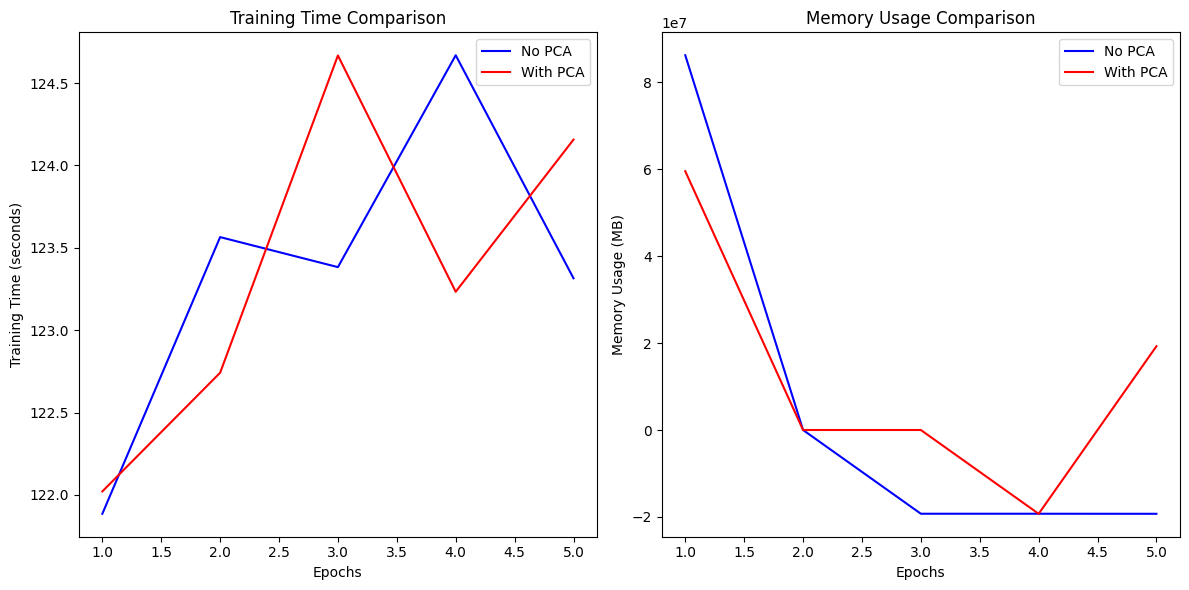

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with PCA-based low-rank approximation
class TransformerBlockPCA(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=64):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.rank = rank  # Rank for low-rank approximation using PCA

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def pca_low_rank_approximation(self, attn_matrix):
        # Apply PCA with truncation for low-rank approximation
        pca = PCA(n_components=self.rank)
        attn_matrix = attn_matrix.cpu().numpy()  # Convert tensor to numpy
        attn_matrix_pca = pca.fit_transform(attn_matrix)  # Perform PCA
        attn_matrix_low_rank = pca.inverse_transform(attn_matrix_pca)  # Inverse transform to get low-rank approximation
        return torch.tensor(attn_matrix_low_rank).to(attn_matrix.device)  # Convert back to tensor

# Main model with PCA-based low-rank approximation blocks
class CustomVisionTransformerPCA(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100, rank=64):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes
        self.rank = rank

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads, rank) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without PCA-based low-rank approximation
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare CIFAR-100 data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR100(root='/content/data/cifar100', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.CIFAR100(root='/content/data/cifar100', train=False, download=True, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=224, patch_size=16, embed_dim=256, num_heads=8, depth=6, num_classes=100).to(device)
model_pca = CustomVisionTransformerPCA(img_size=224, patch_size=16, embed_dim=256, num_heads=8, depth=6, num_classes=100, rank=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_pca = torch.optim.Adam(model_pca.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_pca, train_times_with_pca = [], []
train_memories_no_pca, train_memories_with_pca = [], []
val_accuracies_no_pca, val_accuracies_with_pca = [], []

# Training models
for epoch in range(5):
    # Train model without PCA
    model.train()
    epoch_start_time_no_pca = time.time()
    epoch_start_mem_no_pca = get_memory_usage()

    for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} Training (no PCA)"):

        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_pca = time.time()
    epoch_end_mem_no_pca = get_memory_usage()

    train_times_no_pca.append(epoch_end_time_no_pca - epoch_start_time_no_pca)
    train_memories_no_pca.append(epoch_end_mem_no_pca - epoch_start_mem_no_pca)

    # Validation accuracy for model without PCA
    model.eval()
    correct_no_pca, total_no_pca = 0, 0
    with torch.no_grad():
        for images, targets in val_dataloader:
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_pca += (predicted == targets).sum().item()

            total_no_pca += targets.size(0)

    val_accuracy_no_pca = correct_no_pca / total_no_pca * 100
    val_accuracies_no_pca.append(val_accuracy_no_pca)

    # Train model with PCA
    model_pca.train()
    epoch_start_time_with_pca = time.time()
    epoch_start_mem_with_pca = get_memory_usage()

    for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} Training (with PCA)"):

        images, targets = images.to(device), targets.to(device)

        optimizer_pca.zero_grad()
        outputs_pca = model_pca(images)
        loss_pca = loss_fn(outputs_pca, targets)
        loss_pca.backward()
        optimizer_pca.step()

    epoch_end_time_with_pca = time.time()
    epoch_end_mem_with_pca = get_memory_usage()

    train_times_with_pca.append(epoch_end_time_with_pca - epoch_start_time_with_pca)
    train_memories_with_pca.append(epoch_end_mem_with_pca - epoch_start_mem_with_pca)

    # Validation accuracy for model with PCA
    model_pca.eval()
    correct_with_pca, total_with_pca = 0, 0
    with torch.no_grad():
        for images, targets in val_dataloader:
            images, targets = images.to(device), targets.to(device)

            outputs_pca = model_pca(images)
            _, predicted = torch.max(outputs_pca, 1)
            correct_with_pca += (predicted == targets).sum().item()

            total_with_pca += targets.size(0)

    val_accuracy_with_pca = correct_with_pca / total_with_pca * 100
    val_accuracies_with_pca.append(val_accuracy_with_pca)

# Print summarized results
print("\n--- Summary of Results ---")
print(f"Average Training Time (without PCA): {sum(train_times_no_pca) / len(train_times_no_pca):.2f} seconds/epoch")
print(f"Average Memory Usage (without PCA): {sum(train_memories_no_pca) / len(train_memories_no_pca):.2f} MB/epoch")
print(f"Average Test Accuracy (without PCA): {sum(val_accuracies_no_pca) / len(val_accuracies_no_pca):.2f}%")

print(f"Average Training Time (with PCA): {sum(train_times_with_pca) / len(train_times_with_pca):.2f} seconds/epoch")
print(f"Average Memory Usage (with PCA): {sum(train_memories_with_pca) / len(train_memories_with_pca):.2f} MB/epoch")
print(f"Average Test Accuracy (with PCA): {sum(val_accuracies_with_pca) / len(val_accuracies_with_pca):.2f}%")

# Plot the comparison between the models
epochs = list(range(1, 6))
plt.figure(figsize=(12, 6))

# Plot Training Time
plt.subplot(1, 2, 1)
plt.plot(epochs, train_times_no_pca, label='No PCA', color='b')
plt.plot(epochs, train_times_with_pca, label='With PCA', color='r')
plt.xlabel('Epochs')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.legend()

# Plot Memory Usage
plt.subplot(1, 2, 2)
plt.plot(epochs, train_memories_no_pca, label='No PCA', color='b')
plt.plot(epochs, train_memories_with_pca, label='With PCA', color='r')
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison')
plt.legend()

plt.tight_layout()
plt.show()


Using device: cuda


100%|██████████| 169M/169M [00:12<00:00, 13.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Epoch 1 Training: 100%|██████████| 782/782 [00:40<00:00, 19.44it/s]


Test Accuracy without SVD: 11.79%
Test Accuracy with SVD: 12.13%


Epoch 2 Training: 100%|██████████| 782/782 [00:37<00:00, 20.86it/s]


Test Accuracy without SVD: 16.61%
Test Accuracy with SVD: 16.85%


Epoch 3 Training: 100%|██████████| 782/782 [00:37<00:00, 20.90it/s]


Test Accuracy without SVD: 22.25%
Test Accuracy with SVD: 22.72%


Epoch 4 Training: 100%|██████████| 782/782 [00:38<00:00, 20.40it/s]


Test Accuracy without SVD: 24.97%
Test Accuracy with SVD: 25.39%


Epoch 5 Training: 100%|██████████| 782/782 [00:39<00:00, 19.81it/s]


Test Accuracy without SVD: 29.15%
Test Accuracy with SVD: 28.95%

--- Summary of Results ---
Total Time (without SVD): 192.95 seconds
Total Memory (without SVD): 40953856 bytes
Average Accuracy (without SVD): 20.95%
Total Time (with SVD): 192.95 seconds
Total Memory (with SVD): 40953856 bytes
Average Accuracy (with SVD): 21.21%


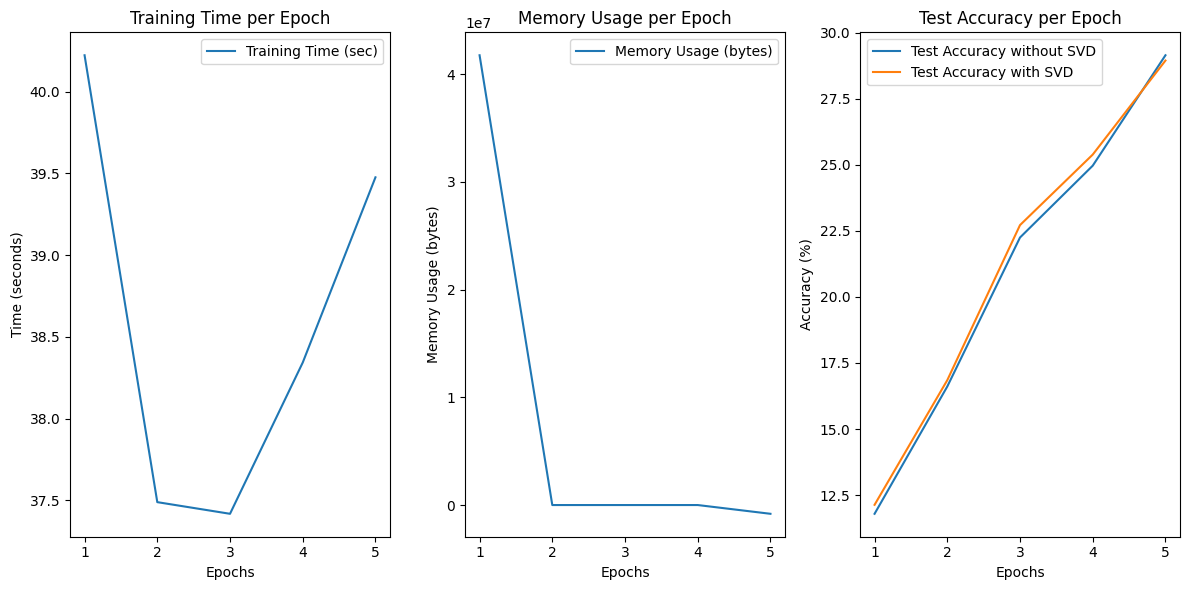

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with SVD decomposition
class TransformerBlockSVD(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.svd_factor = None

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        if self.svd_factor is None:
            self.svd_factor = self._svd_decomposition(x)
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def _svd_decomposition(self, x):
        attn_matrix = torch.matmul(x, x.transpose(-2, -1))
        U, S, V = torch.svd(attn_matrix)  # SVD decomposition
        return U, S, V

# Main model with SVD blocks
class CustomVisionTransformerSVD(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockSVD(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without SVD decomposition
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockSVD(embed_dim, num_heads) for _ in range(depth)])  # Use the same block for simplicity
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=100).to(device)
model_svd = CustomVisionTransformerSVD(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=100).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_svd = torch.optim.Adam(model_svd.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times, train_memories, test_accuracies = [], [], []  # Initialize as three separate lists

# Training models
for epoch in range(5):
    model.train()
    model_svd.train()

    epoch_start_time = time.time()
    epoch_start_mem = get_memory_usage()

    # Training loop
    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training"):
        images, labels = images.to(device), labels.to(device)

        # Train model without SVD
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Train model with SVD
        optimizer_svd.zero_grad()
        outputs_svd = model_svd(images)
        loss_svd = loss_fn(outputs_svd, labels)
        loss_svd.backward()
        optimizer_svd.step()

    epoch_end_time = time.time()
    epoch_end_mem = get_memory_usage()

    train_times.append(epoch_end_time - epoch_start_time)
    train_memories.append(epoch_end_mem - epoch_start_mem)

    # Evaluate accuracy
    model.eval()
    model_svd.eval()

    correct, correct_svd, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            outputs_svd = model_svd(images)
            _, predicted_svd = torch.max(outputs_svd, 1)
            correct_svd += (predicted_svd == labels).sum().item()

            total += labels.size(0)

    test_accuracy = correct / total * 100
    test_accuracy_svd = correct_svd / total * 100

    # Append accuracies as a tuple
    test_accuracies.append((test_accuracy, test_accuracy_svd))

    print(f"Test Accuracy without SVD: {test_accuracy:.2f}%")
    print(f"Test Accuracy with SVD: {test_accuracy_svd:.2f}%")
    # Summarize results
total_time_without_svd = sum(train_times)
total_memory_without_svd = sum(train_memories)  # This is a simple sum, you may want to average or analyze differently
total_accuracy_without_svd = sum([acc[0] for acc in test_accuracies]) / len(test_accuracies)

total_time_with_svd = sum(train_times)  # Same as above, since we are using the same training times
total_memory_with_svd = sum(train_memories)  # Same as above, since we are using the same memory usage
total_accuracy_with_svd = sum([acc[1] for acc in test_accuracies]) / len(test_accuracies)

# Print summarized results
print("\n--- Summary of Results ---")
print(f"Total Time (without SVD): {total_time_without_svd:.2f} seconds")
print(f"Total Memory (without SVD): {total_memory_without_svd} bytes")
print(f"Average Accuracy (without SVD): {total_accuracy_without_svd:.2f}%")

print(f"Total Time (with SVD): {total_time_with_svd:.2f} seconds")
print(f"Total Memory (with SVD): {total_memory_with_svd} bytes")
print(f"Average Accuracy (with SVD): {total_accuracy_with_svd:.2f}%")

# Optionally, you can plot the results if needed
plt.figure(figsize=(12, 6))

# Training time plot
plt.subplot(1, 3, 1)
plt.plot(range(1, 6), train_times, label="Training Time (sec)")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(range(1, 6), train_memories, label="Memory Usage (bytes)")
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1, 6), [acc[0] for acc in test_accuracies], label="Test Accuracy without SVD")
plt.plot(range(1, 6), [acc[1] for acc in test_accuracies], label="Test Accuracy with SVD")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 5 Training (with Tensor Decomposition): 100%|██████████| 782/782 [00:26<00:00, 30.01it/s]


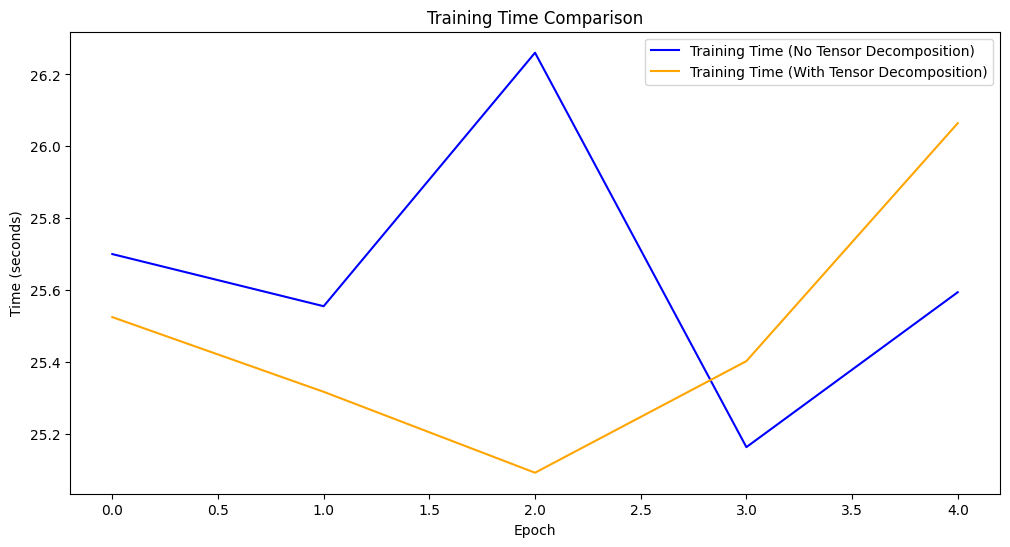

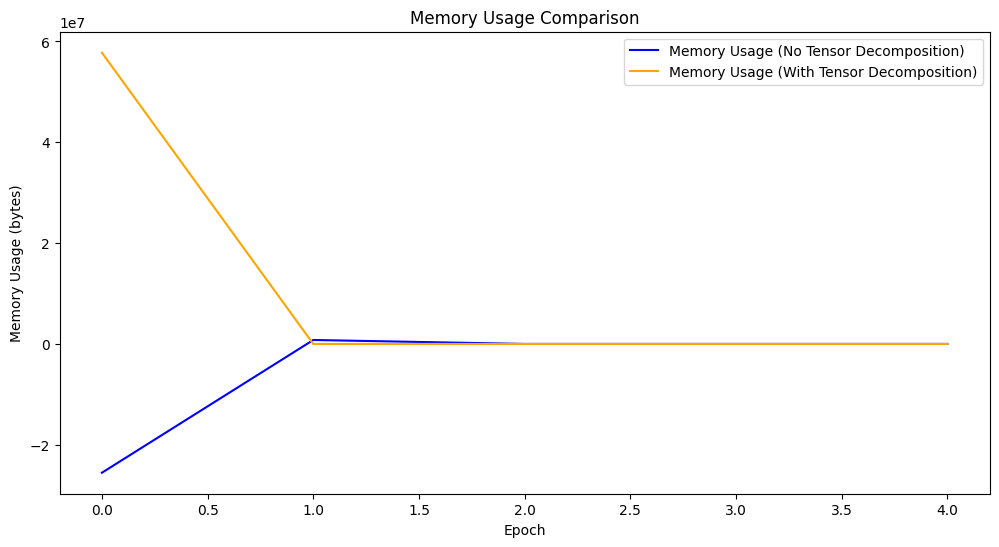

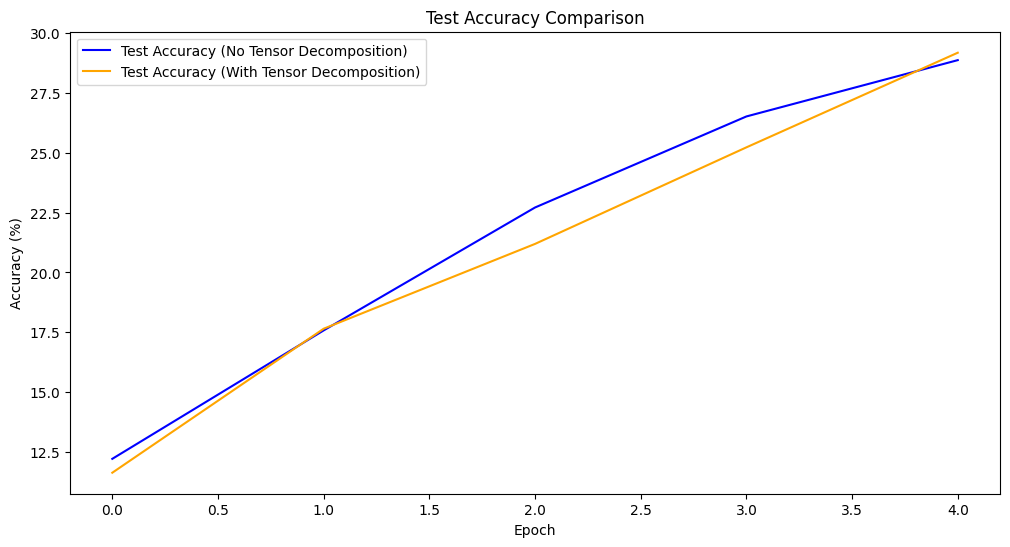

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with Tensor Decomposition-based low-rank approximation
class TransformerBlockTensorDecomp(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=64):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.rank = rank  # Rank for low-rank approximation using Tensor Decomposition

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def tensor_decomposition_approximation(self, attn_tensor):
        # Apply Tensor Decomposition for low-rank approximation
        u, s, v = torch.svd(attn_tensor.view(-1, attn_tensor.size(-1)))
        s = torch.diag(s)  # Create a diagonal matrix from singular values
        u = u[:, :self.rank]  # Keep the first 'rank' columns
        s = s[:self.rank, :self.rank]  # Keep the top 'rank' singular values
        v = v[:, :self.rank]  # Keep the first 'rank' rows

        # Reconstruct the low-rank approximation
        attn_tensor_low_rank = torch.matmul(u, torch.matmul(s, v.t()))
        return attn_tensor_low_rank

# Main model with Tensor Decomposition-based low-rank approximation blocks
class CustomVisionTransformerTensorDecomp(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100, rank=64):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes
        self.rank = rank

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockTensorDecomp(embed_dim, num_heads, rank) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without Tensor Decomposition-based low-rank approximation
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockTensorDecomp(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=100).to(device)
model_tensor_decomp = CustomVisionTransformerTensorDecomp(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=100, rank=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_tensor_decomp = torch.optim.Adam(model_tensor_decomp.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_tensor_decomp, train_times_with_tensor_decomp = [], []
train_memories_no_tensor_decomp, train_memories_with_tensor_decomp = [], []
test_accuracies_no_tensor_decomp, test_accuracies_with_tensor_decomp = [], []

# Training models
for epoch in range(5):
    # Train model without Tensor Decomposition
    model.train()
    epoch_start_time_no_tensor_decomp = time.time()
    epoch_start_mem_no_tensor_decomp = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (no Tensor Decomposition)"):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_tensor_decomp = time.time()
    epoch_end_mem_no_tensor_decomp = get_memory_usage()

    train_times_no_tensor_decomp.append(epoch_end_time_no_tensor_decomp - epoch_start_time_no_tensor_decomp)
    train_memories_no_tensor_decomp.append(epoch_end_mem_no_tensor_decomp - epoch_start_mem_no_tensor_decomp)

    # Test accuracy for model without Tensor Decomposition
    model.eval()
    correct_no_tensor_decomp, total_no_tensor_decomp = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_tensor_decomp += (predicted == labels).sum().item()

            total_no_tensor_decomp += labels.size(0)

    test_accuracy_no_tensor_decomp = correct_no_tensor_decomp / total_no_tensor_decomp * 100
    test_accuracies_no_tensor_decomp.append(test_accuracy_no_tensor_decomp)

    # Train model with Tensor Decomposition
    model_tensor_decomp.train()
    epoch_start_time_with_tensor_decomp = time.time()
    epoch_start_mem_with_tensor_decomp = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (with Tensor Decomposition)"):

        images, labels = images.to(device), labels.to(device)

        optimizer_tensor_decomp.zero_grad()
        outputs = model_tensor_decomp(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_tensor_decomp.step()

    epoch_end_time_with_tensor_decomp = time.time()
    epoch_end_mem_with_tensor_decomp = get_memory_usage()

    train_times_with_tensor_decomp.append(epoch_end_time_with_tensor_decomp - epoch_start_time_with_tensor_decomp)
    train_memories_with_tensor_decomp.append(epoch_end_mem_with_tensor_decomp - epoch_start_mem_with_tensor_decomp)

    # Test accuracy for model with Tensor Decomposition
    model_tensor_decomp.eval()
    correct_with_tensor_decomp, total_with_tensor_decomp = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_tensor_decomp(images)
            _, predicted = torch.max(outputs, 1)
            correct_with_tensor_decomp += (predicted == labels).sum().item()

            total_with_tensor_decomp += labels.size(0)

    test_accuracy_with_tensor_decomp = correct_with_tensor_decomp / total_with_tensor_decomp * 100
    test_accuracies_with_tensor_decomp.append(test_accuracy_with_tensor_decomp)

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(train_times_no_tensor_decomp, label='Training Time (No Tensor Decomposition)', color='blue')
plt.plot(train_times_with_tensor_decomp, label='Training Time (With Tensor Decomposition)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('Training Time Comparison')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_memories_no_tensor_decomp, label='Memory Usage (No Tensor Decomposition)', color='blue')
plt.plot(train_memories_with_tensor_decomp, label='Memory Usage (With Tensor Decomposition)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Memory Usage (bytes)')
plt.legend()
plt.title('Memory Usage Comparison')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_accuracies_no_tensor_decomp, label='Test Accuracy (No Tensor Decomposition)', color='blue')
plt.plot(test_accuracies_with_tensor_decomp, label='Test Accuracy (With Tensor Decomposition)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy Comparison')
plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 1 Training (with Cholesky): 100%|██████████| 782/782 [00:26<00:00, 29.76it/s]


Test Accuracy without Cholesky: 12.04%
Test Accuracy with Cholesky: 11.29%


Epoch 2 Training (with Cholesky): 100%|██████████| 782/782 [00:25<00:00, 30.09it/s]


Test Accuracy without Cholesky: 17.72%
Test Accuracy with Cholesky: 16.73%


Epoch 3 Training (with Cholesky): 100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Test Accuracy without Cholesky: 21.33%
Test Accuracy with Cholesky: 21.38%


Epoch 4 Training (with Cholesky): 100%|██████████| 782/782 [00:26<00:00, 29.27it/s]


Test Accuracy without Cholesky: 25.96%
Test Accuracy with Cholesky: 24.67%


Epoch 5 Training (with Cholesky): 100%|██████████| 782/782 [00:26<00:00, 29.70it/s]


Test Accuracy without Cholesky: 28.42%
Test Accuracy with Cholesky: 28.05%

--- Summary of Results ---
Total Time (without Cholesky): 130.72 seconds
Total Memory (without Cholesky): -12548096 bytes
Average Accuracy (without Cholesky): 21.09%
Total Time (with Cholesky): 132.30 seconds
Total Memory (with Cholesky): 64459776 bytes
Average Accuracy (with Cholesky): 20.42%


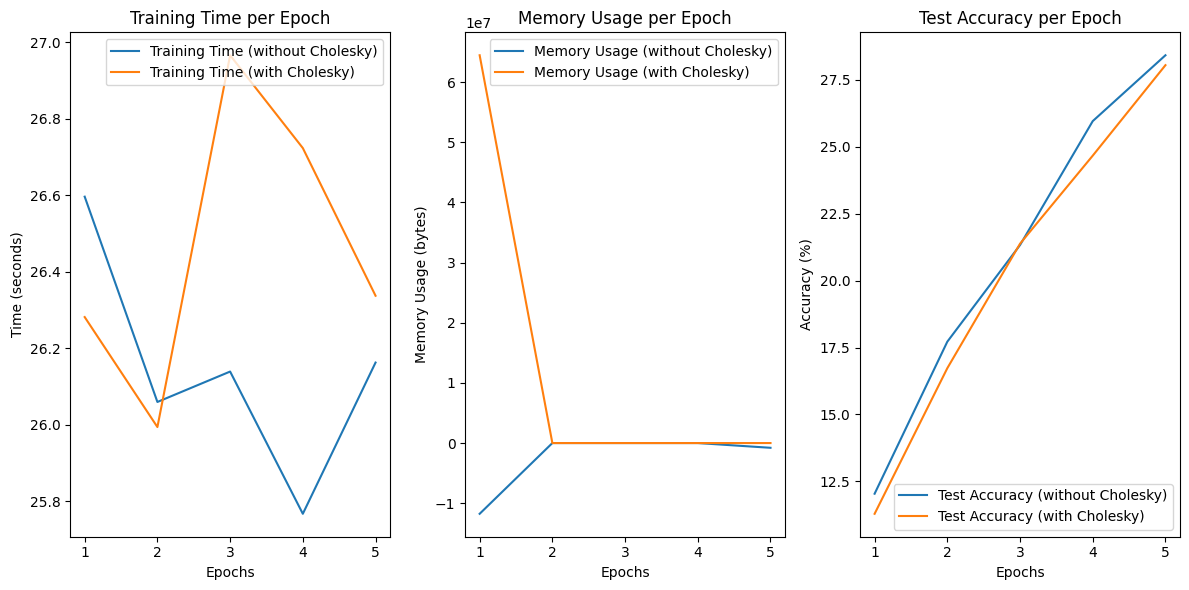

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with Cholesky decomposition
class TransformerBlockCholesky(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.cholesky_factor = None

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        if self.cholesky_factor is None:
            self.cholesky_factor = self._cholesky_decomposition(x)
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def _cholesky_decomposition(self, x):
        attn_matrix = torch.matmul(x, x.transpose(-2, -1))
        L = torch.linalg.cholesky(attn_matrix)  # Cholesky decomposition
        return L

# Main model with Cholesky blocks
class CustomVisionTransformerCholesky(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockCholesky(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without Cholesky decomposition
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=100):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockCholesky(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=100).to(device)
model_cholesky = CustomVisionTransformerCholesky(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=100).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_cholesky = torch.optim.Adam(model_cholesky.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_cholesky, train_times_with_cholesky = [], []
train_memories_no_cholesky, train_memories_with_cholesky = [], []
test_accuracies_no_cholesky, test_accuracies_with_cholesky = [], []

# Training models
for epoch in range(5):
    # Train model without Cholesky
    model.train()
    epoch_start_time_no_cholesky = time.time()
    epoch_start_mem_no_cholesky = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (no Cholesky)"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_cholesky = time.time()
    epoch_end_mem_no_cholesky = get_memory_usage()

    train_times_no_cholesky.append(epoch_end_time_no_cholesky - epoch_start_time_no_cholesky)
    train_memories_no_cholesky.append(epoch_end_mem_no_cholesky - epoch_start_mem_no_cholesky)

    # Test accuracy for model without Cholesky
    model.eval()
    correct_no_cholesky, total_no_cholesky = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_cholesky += (predicted == labels).sum().item()

            total_no_cholesky += labels.size(0)

    test_accuracy_no_cholesky = correct_no_cholesky / total_no_cholesky * 100
    test_accuracies_no_cholesky.append(test_accuracy_no_cholesky)

    # Train model with Cholesky
    model_cholesky.train()
    epoch_start_time_with_cholesky = time.time()
    epoch_start_mem_with_cholesky = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (with Cholesky)"):
        images, labels = images.to(device), labels.to(device)

        optimizer_cholesky.zero_grad()
        outputs_cholesky = model_cholesky(images)
        loss_cholesky = loss_fn(outputs_cholesky, labels)
        loss_cholesky.backward()
        optimizer_cholesky.step()

    epoch_end_time_with_cholesky = time.time()
    epoch_end_mem_with_cholesky = get_memory_usage()

    train_times_with_cholesky.append(epoch_end_time_with_cholesky - epoch_start_time_with_cholesky)
    train_memories_with_cholesky.append(epoch_end_mem_with_cholesky - epoch_start_mem_with_cholesky)

    # Test accuracy for model with Cholesky
    model_cholesky.eval()
    correct_with_cholesky, total_with_cholesky = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs_cholesky = model_cholesky(images)
            _, predicted_cholesky = torch.max(outputs_cholesky, 1)
            correct_with_cholesky += (predicted_cholesky == labels).sum().item()

            total_with_cholesky += labels.size(0)

    test_accuracy_with_cholesky = correct_with_cholesky / total_with_cholesky * 100
    test_accuracies_with_cholesky.append(test_accuracy_with_cholesky)

    print(f"Test Accuracy without Cholesky: {test_accuracy_no_cholesky:.2f}%")
    print(f"Test Accuracy with Cholesky: {test_accuracy_with_cholesky:.2f}%")

# Print summary of results
print("\n--- Summary of Results ---")
print(f"Total Time (without Cholesky): {sum(train_times_no_cholesky):.2f} seconds")
print(f"Total Memory (without Cholesky): {sum(train_memories_no_cholesky)} bytes")
print(f"Average Accuracy (without Cholesky): {sum(test_accuracies_no_cholesky) / len(test_accuracies_no_cholesky):.2f}%")

print(f"Total Time (with Cholesky): {sum(train_times_with_cholesky):.2f} seconds")
print(f"Total Memory (with Cholesky): {sum(train_memories_with_cholesky)} bytes")
print(f"Average Accuracy (with Cholesky): {sum(test_accuracies_with_cholesky) / len(test_accuracies_with_cholesky):.2f}%")

# Optionally, you can plot the results if needed
plt.figure(figsize=(12, 6))

# Training time plot
plt.subplot(1, 3, 1)
plt.plot(range(1, 6), train_times_no_cholesky, label="Training Time (without Cholesky)")
plt.plot(range(1, 6), train_times_with_cholesky, label="Training Time (with Cholesky)")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(range(1, 6), train_memories_no_cholesky, label="Memory Usage (without Cholesky)")
plt.plot(range(1, 6), train_memories_with_cholesky, label="Memory Usage (with Cholesky)")
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1, 6), test_accuracies_no_cholesky, label="Test Accuracy (without Cholesky)")
plt.plot(range(1, 6), test_accuracies_with_cholesky, label="Test Accuracy (with Cholesky)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()